In [68]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Activation, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, LearningRateScheduler
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

In [69]:
(x_train, _), (x_test, _) = cifar10.load_data()


In [70]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [71]:
noise_factor = 0.5
xTrain_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=0.3, size=x_train.shape)
xTest_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=0.3, size=x_test.shape)
xTrain_noisy = np.clip(xTrain_noisy, 0., 1.)
xTest_noisy = np.clip(xTest_noisy, 0., 1.)

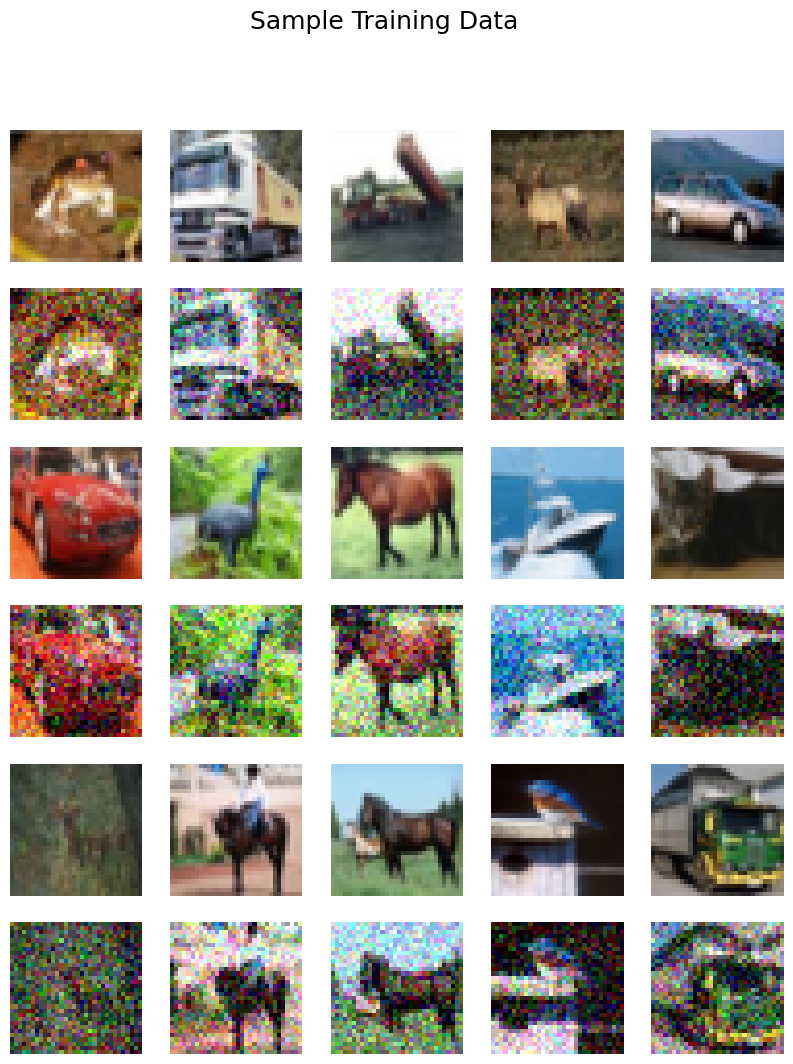

In [72]:
rows = 3 # defining no. of rows in figure
cols = 5 # defining no. of colums in figure

f = plt.figure(figsize = (2 * cols, 2 * rows * 2)) # defining a figure

for i in range(rows):
    for j in range(cols):
        f.add_subplot(rows * 2, cols, (2 * i * cols) + (j + 1)) # adding sub plot to figure on each iteration
        plt.imshow(x_train[i * cols + j])
        plt.axis("off")

    for j in range(cols):
        f.add_subplot(rows * 2, cols, ((2 * i + 1) * cols) + (j + 1)) # adding sub plot to figure on each iteration
        plt.imshow(xTrain_noisy[i * cols + j])
        plt.axis("off")

f.suptitle("Sample Training Data", fontsize = 18)
plt.savefig("Cifar-trian.png")

plt.show()

In [73]:
def ConvBlock(x, filters, kernel_size, strides = 2):
    x = Conv2D(filters = filters,
               kernel_size = kernel_size,
               strides = strides,
               padding = 'same',
               activation = 'relu',
               kernel_regularizer = regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    return x

def DeconvBlock(x, filters, kernel_size):
    x = Conv2DTranspose(filters = filters,
                        kernel_size = kernel_size,
                        strides = 2,
                        padding = 'same',
                        activation = 'relu',
                        kernel_regularizer = regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    return x

In [74]:
def autoencoder():
    inputs = Input(shape = (32, 32, 3), name = 'inputs')
    cb1 = ConvBlock(inputs, 32, 3)
    cb2 = ConvBlock(cb1, 64, 3)
    cb3 = ConvBlock(cb2, 128, 3)
    cb4 = ConvBlock(cb3, 256, 3)
    cb5 = ConvBlock(cb4, 256, 3)
    cb6 = ConvBlock(cb5, 512, 3, 1)

    dcb1 = DeconvBlock(cb6, 512, 3)
    merge1 = Concatenate()([dcb1, cb4])
    dcb2 = DeconvBlock(merge1, 256, 3)
    merge2 = Concatenate()([dcb2, cb3])
    dcb3 = DeconvBlock(merge2, 128, 3)
    merge3 = Concatenate()([dcb3, cb2])
    dcb4 = DeconvBlock(merge3, 64, 3)
    merge4 = Concatenate()([dcb4, cb1])
    dcb5 = DeconvBlock(merge4, 32, 3)

    final_deconv = Conv2DTranspose(filters = 3, kernel_size = 3, padding = 'same')(dcb5)
    outputs = Activation('sigmoid', name = 'output')(final_deconv)
    return Model(inputs, outputs, name = 'autoencoder')


In [75]:
model = autoencoder()

def scheduler(epoch):
    if epoch < 10:
        return 0.0001
    else:
        return 0.0001 * tf.math.exp(0.1 * (10 - epoch))

class myCallback(Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if(logs.get('accuracy') > 0.80):
            print("\nReached 80% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

lr = LearningRateScheduler(scheduler)
checkpoint = ModelCheckpoint('best_model.h5', verbose = 1, save_best_only = True, save_weights_only = True)

model.compile(optimizer = "adam", loss = 'mse', metrics=["accuracy"])
model.summary()


Model: "autoencoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_21 (Conv2D)          (None, 16, 16, 32)           896       ['inputs[0][0]']              
                                                                                                  
 batch_normalization_22 (Ba  (None, 16, 16, 32)           128       ['conv2d_21[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv2d_22 (Conv2D)          (None, 8, 8, 64)             18496     ['batch_normalizatio

In [76]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [77]:
history = model.fit(xTrain_noisy, x_train, validation_data = (xTest_noisy, x_test),
                    epochs = 25,batch_size = 128, shuffle = True,
                    callbacks = [checkpoint, callbacks, lr])

Epoch 1/25
391/391 [==============================] - ETA: 0s - loss: 0.6229 - accuracy: 0.5341
Epoch 1: val_loss improved from inf to 0.10062, saving model to best_model.h5
391/391 [==============================] - 27s 51ms/step - loss: 0.6229 - accuracy: 0.5341 - val_loss: 0.1006 - val_accuracy: 0.5809 - lr: 1.0000e-04
Epoch 2/25
390/391 [============================>.] - ETA: 0s - loss: 0.0410 - accuracy: 0.6681
Epoch 2: val_loss improved from 0.10062 to 0.02161, saving model to best_model.h5
391/391 [==============================] - 18s 46ms/step - loss: 0.0410 - accuracy: 0.6682 - val_loss: 0.0216 - val_accuracy: 0.6752 - lr: 1.0000e-04
Epoch 3/25
391/391 [==============================] - ETA: 0s - loss: 0.0125 - accuracy: 0.7172
Epoch 3: val_loss improved from 0.02161 to 0.01113, saving model to best_model.h5
391/391 [==============================] - 20s 50ms/step - loss: 0.0125 - accuracy: 0.7172 - val_loss: 0.0111 - val_accuracy: 0.7088 - lr: 1.0000e-04
Epoch 4/25
390/391 [

In [78]:
nImgs = 48
rand = np.random.randint(1, xTest_noisy.shape[0]-48)

cifar_test_images = xTest_noisy[rand:rand+nImgs] # slicing
cifar_test_predicted = model.predict(cifar_test_images) # predict

2/2 [==============================] - 0s 8ms/step


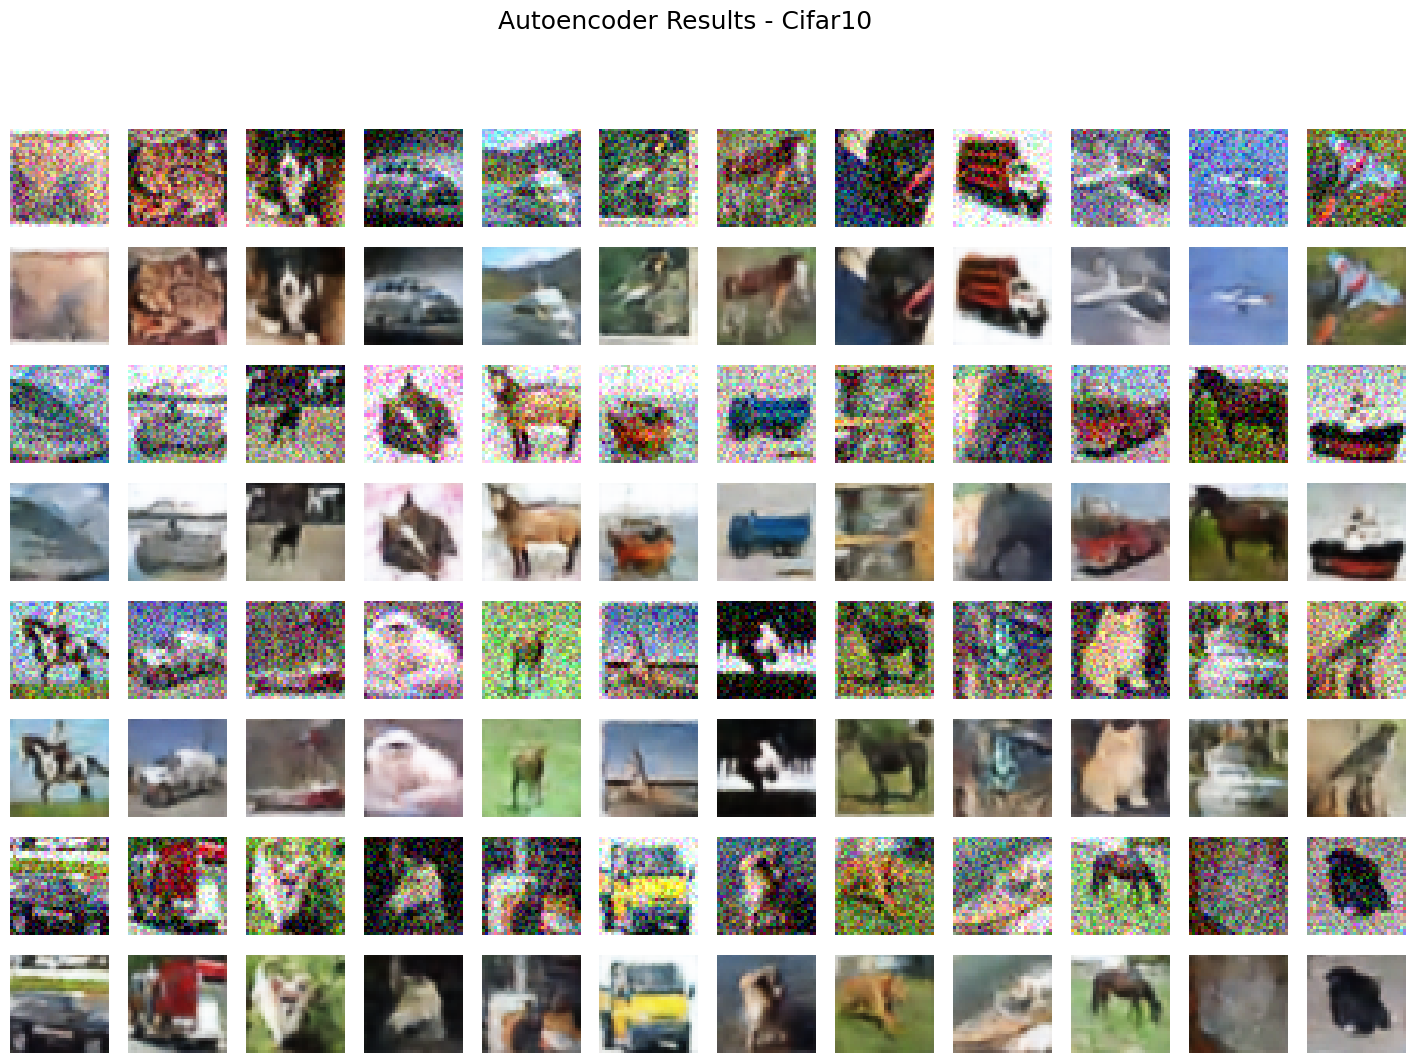

In [79]:
rows = 4 # defining no. of rows in figure
cols = 12 # defining no. of colums in figure
cell_size = 1.5
f = plt.figure(figsize=(cell_size*cols,cell_size*rows*2)) # defining a figure
f.tight_layout()
for i in range(rows):
    for j in range(cols):
        f.add_subplot(rows * 2, cols, (2 * i * cols) + (j + 1)) # adding sub plot to figure on each iteration
        plt.imshow(cifar_test_images[i * cols + j])
        plt.axis("off")

    for j in range(cols):
        f.add_subplot(rows * 2, cols, ((2 * i+ 1) * cols) + (j + 1)) # adding sub plot to figure on each iteration
        plt.imshow(cifar_test_predicted[i * cols + j])
        plt.axis("off")

f.suptitle("Autoencoder Results - Cifar10",fontsize=18)
plt.savefig("test_results_cifar10.png")

plt.show()
